# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [1]:
import numpy as np
import os
import glob
from skimage.measure import label
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from skimage import morphology
from scipy.stats import iqr
from scipy.stats import binom_test

C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [86]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

def calculate_overlap(mask_1, mask_2):
    o = 0
    if (np.sum(mask_1)>0)&(np.sum(mask_2)>0):
        intersection = np.sum(mask_1*mask_2)
        min_area = min(np.sum(mask_1), np.sum(mask_2))
        o =intersection/min_area
    if (np.sum(mask_1)==0)&(np.sum(mask_2)==0):
        o = 1
    return o

In [3]:
def path2array(dcm_path, cut=True):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    if cut:
        arr = arr[8:-8,8:-8]
    return arr

In [4]:
def detect_label(label_mask, gt_mask):
    
    max_overlap = 0
    max_label = 100
    max_dice = 0
    
    for l in range(1, np.max(label_mask)+1):
        
        label_mask_l = label_mask==l
        d = calculate_dice(label_mask_l, gt_mask)
        o = calculate_overlap(label_mask_l, gt_mask)
        
        if o>max_overlap:
            
            max_overlap = o
            max_label = l
            max_dice = d        
            
    return max_label, max_overlap, max_dice

In [5]:
import scipy.stats
import math
import random


def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [140]:
def get_outcomes_mapstrategy(sub_names, ds_dir, results_dir, cut=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    for sub_name in sub_names:
        
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        mask3d_pred = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.float)
        mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []

        detected=0

        for filename in filenames:

            sl = filename[-17:-11]
            
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]

            mask2d_gt = (path2array(gt_path, cut=cut)>0)&(path2array(gt_path, cut=cut)<7)
            mask2d_pred = np.load(pred_path)
            
            mask2d_pred_processed = morphology.remove_small_objects(mask2d_pred>0.5, 50, connectivity=3)
            mask2d_pred_labeled = label(mask2d_pred_processed)

            label_weights = []

            for l in range(1, np.max(mask2d_pred_labeled)+1):

                mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
                weight_label = np.sum(mask2d_pred_label*mask2d_pred)
                rec_lw = {'label': l, 'weight': weight_label}
                label_weights.append(rec_lw)

            label_weights = pd.DataFrame(label_weights)
            n_labels = min(len(label_weights), 6)
            labels = []
            
            if len(label_weights)>0:
                label_weights.sort_values(by='weight', inplace=True, ascending = False)
                labels = np.array(label_weights['label'])[:n_labels]

            detected = 0
            max_overlap = 0
            max_label = 100
            max_dice = 0            
        
            for l in labels:

                mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
                d = calculate_dice(mask2d_pred_label, mask2d_gt)
                o = calculate_overlap(mask2d_pred_label, mask2d_gt)

                if o>max_overlap:

                    max_overlap = o
                    max_label = l
                    max_dice = d

            if (max_overlap>0.5):
                detected = 1
                
            mask3d_gt[:, :, counter] = mask2d_gt
            mask3d_pred[:, :, counter] = (mask2d_pred_labeled==max_label).astype(np.uint8)
            
            detect_slice_sub.append(detected)
            dice_slice_sub.append(max_dice)
            overlap_slice_sub.append(max_overlap)
            
            detect_slice.append(detected)
            dice_slice.append(max_dice)
            overlap_slice.append(max_overlap)
            
            counter+=1
            
        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub
        
        rec['detect_patient'] = int(calculate_overlap(mask3d_pred, mask3d_gt)>0.5)
        rec['overlap_patient'] = calculate_overlap(mask3d_pred, mask3d_gt)
        rec['dice_patient'] = calculate_dice(mask3d_pred, mask3d_gt)

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
        
    print ('Slice\n')

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.hist(detect_slice)
    plt.title('TPR')

    plt.subplot(1, 3, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 3, 3)
    plt.hist(dice_slice)
    plt.title('DSC')

    plt.show()

    print ('Patient\n')

    print ('Mean TPR, OC, DSC: ', 
           np.mean(df_outcomes['detect_patient']), 
           np.mean(df_outcomes['overlap_patient']), 
           np.mean(df_outcomes['dice_patient']))

    print ('Median TPR, OC, DSC: ',
           np.median(df_outcomes['detect_patient']), 
           np.median(df_outcomes['overlap_patient']), 
           np.median(df_outcomes['dice_patient']))

    print ('IQR TPR, OC, DSC: ',
           iqr(df_outcomes['detect_patient']), 
           iqr(df_outcomes['overlap_patient']), 
           iqr(df_outcomes['dice_patient']))

    print ('CP 90% CI TPR: ',
           clopper_pearson(x=np.sum(np.array(df_outcomes['detect_patient'])), 
                           n=len(np.array(df_outcomes['detect_patient'])), alpha=0.1))
    
    return df_outcomes

In [153]:
def get_outcomes_maskstrategy(sub_names, ds_dir, results_dir, cut=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    for sub_name in sub_names:
        
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        mask3d_pred = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.float)
        mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []

        detected=0

        for filename in filenames:

            sl = filename[-17:-11]
            
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]

            mask2d_gt = (path2array(gt_path, cut=cut)>0)&(path2array(gt_path, cut=cut)<7)
            mask2d_pred = np.load(pred_path)
            
            mask2d_pred_labeled = label(mask2d_pred)

            labels = list(np.unique(mask2d_pred_labeled))
            labels.remove(0)
            
            detected = 0
            max_overlap = 0
            max_label = 100
            max_dice = 0  
            
            if len(labels)>0:
                
                for l in labels:

                    mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
                    d = calculate_dice(mask2d_pred_label, mask2d_gt)
                    o = calculate_overlap(mask2d_pred_label, mask2d_gt)

                    if o>max_overlap:

                        max_overlap = o
                        max_label = l
                        max_dice = d

                if (max_overlap>0.5):
                    detected = 1
                
            mask3d_gt[:, :, counter] = mask2d_gt
            mask3d_pred[:, :, counter] = (mask2d_pred_labeled==max_label).astype(np.uint8)
            
            detect_slice_sub.append(detected)
            dice_slice_sub.append(max_dice)
            overlap_slice_sub.append(max_overlap)
            
            detect_slice.append(detected)
            dice_slice.append(max_dice)
            overlap_slice.append(max_overlap)
            
            counter+=1
            
        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub
        
        rec['detect_patient'] = int(calculate_overlap(mask3d_pred, mask3d_gt)>0.5)
        rec['overlap_patient'] = calculate_overlap(mask3d_pred, mask3d_gt)
        rec['dice_patient'] = calculate_dice(mask3d_pred, mask3d_gt)

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
        
    print ('Slice\n')

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.hist(detect_slice)
    plt.title('TPR')

    plt.subplot(1, 3, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 3, 3)
    plt.hist(dice_slice)
    plt.title('DSC')

    plt.show()

    print ('Patient\n')

    print ('Mean TPR, OC, DSC: ', 
           np.mean(df_outcomes['detect_patient']), 
           np.mean(df_outcomes['overlap_patient']), 
           np.mean(df_outcomes['dice_patient']))

    print ('Median TPR, OC, DSC: ',
           np.median(df_outcomes['detect_patient']), 
           np.median(df_outcomes['overlap_patient']), 
           np.median(df_outcomes['dice_patient']))

    print ('IQR TPR, OC, DSC: ',
           iqr(df_outcomes['detect_patient']), 
           iqr(df_outcomes['overlap_patient']), 
           iqr(df_outcomes['dice_patient']))

    print ('CP 90% CI TPR: ',
           clopper_pearson(x=np.sum(np.array(df_outcomes['detect_patient'])), 
                           n=len(np.array(df_outcomes['detect_patient'])), alpha=0.1))
    
    return df_outcomes

# Test subset

In [128]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [130]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/u-net_simple/'
results_dir_aug = '../res/maps/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.6940509915014165 0.665551939842086 0.6070540698868833
Median TPR, OC, DSC:  1.0 0.9540229885057471 0.8565737051792829
IQR TPR, OC, DSC:  1.0 0.9845559845559846 0.9335071707953064
CP 90% CI TPR:  (0.6511736142769085, 0.7344834080178415)


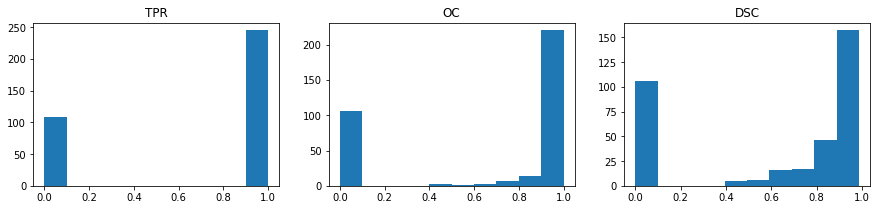

Patient

Mean TPR, OC, DSC:  1.0 0.8688971204198411 0.7343667996846416
Median TPR, OC, DSC:  1.0 0.9008609487185879 0.7772818198333489
IQR TPR, OC, DSC:  0.0 0.11954876382845336 0.12958355605916505
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [141]:
df_outcomes_test_unet_simple = get_outcomes_mapstrategy(sub_names_test, ds_dir, results_dir_simple)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.7535410764872521 0.7283644552801395 0.6824408124759502
Median TPR, OC, DSC:  1.0 0.9593023255813954 0.9046679815910585
IQR TPR, OC, DSC:  0.0 0.30954131035634125 0.41517967811332046
CP 90% CI TPR:  (0.7128828909526761, 0.7909955565553424)


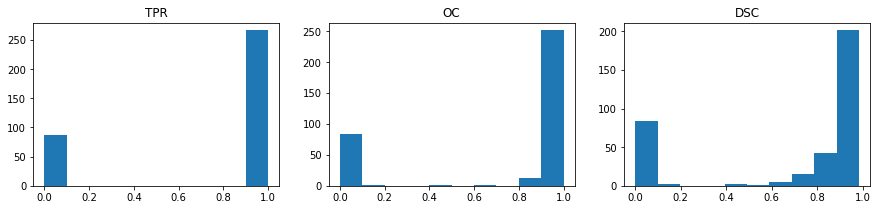

Patient

Mean TPR, OC, DSC:  1.0 0.8870930926135939 0.7970081368229689
Median TPR, OC, DSC:  1.0 0.8959162411738915 0.8140435394748755
IQR TPR, OC, DSC:  0.0 0.07199857999013948 0.10327614561731557
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [142]:
df_outcomes_test_unet_aug = get_outcomes_mapstrategy(sub_names_test, ds_dir, results_dir_aug)

In [143]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/plaq-u-net_simple/'
results_dir_aug = '../res/maps/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8810198300283286 0.8735649802509556 0.6628093481772142
Median TPR, OC, DSC:  1.0 1.0 0.7759131293188549
IQR TPR, OC, DSC:  0.0 0.0210280373831776 0.3055199425373033
CP 90% CI TPR:  (0.8488417781993098, 0.9083132276976742)


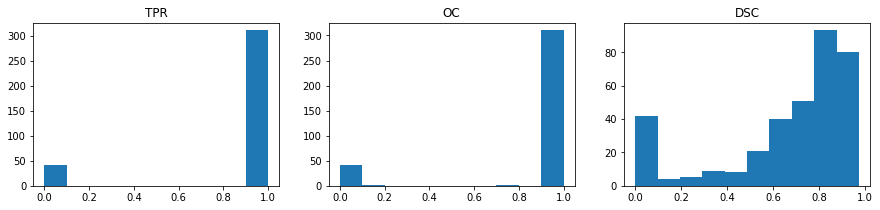

Patient

Mean TPR, OC, DSC:  1.0 0.9825125522225692 0.702918965405336
Median TPR, OC, DSC:  1.0 0.9927299933252081 0.7156042489432819
IQR TPR, OC, DSC:  0.0 0.011740968347268566 0.16757694063608275
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [144]:
df_outcomes_test_plaqunet_simple = get_outcomes_mapstrategy(sub_names_test, ds_dir, results_dir_simple)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8555240793201133 0.8364612843628397 0.7579096497369702
Median TPR, OC, DSC:  1.0 0.9838056680161943 0.901686121919585
IQR TPR, OC, DSC:  0.0 0.04010314559587025 0.1687665328123118
CP 90% CI TPR:  (0.8211032155685053, 0.885407878689607)


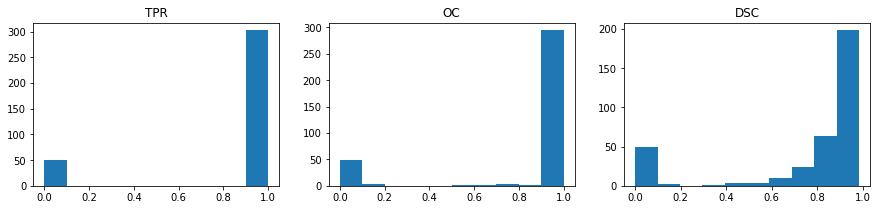

Patient

Mean TPR, OC, DSC:  1.0 0.9262077763219093 0.8173025674337057
Median TPR, OC, DSC:  1.0 0.9533367046708349 0.8284117877060544
IQR TPR, OC, DSC:  0.0 0.07610863501002141 0.10619457375360253
CP 90% CI TPR:  (0.8826538438450513, 1.0)


In [145]:
df_outcomes_test_plaqunet_aug = get_outcomes_mapstrategy(sub_names_test, ds_dir, results_dir_aug)

In [154]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/mask-rcnn_simple/'
results_dir_aug = '../res/maps/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.32294617563739375 0.3156567468211877 0.2663843425076842
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  1.0 0.9627831715210357 0.7728937728937729
CP 90% CI TPR:  (0.2818146507598959, 0.36630715599401037)


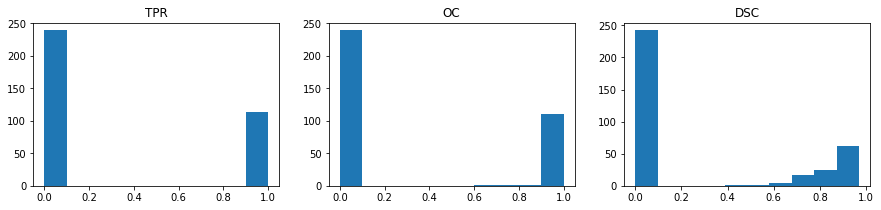

Patient

Mean TPR, OC, DSC:  0.9166666666666666 0.8735407355169976 0.365478940257417
Median TPR, OC, DSC:  1.0 0.9673472694023972 0.4559290015744785
IQR TPR, OC, DSC:  0.0 0.05312588028647647 0.33154116100129005
CP 90% CI TPR:  (0.7601989838711982, 0.9849882212364126)


In [155]:
df_outcomes_test_maskrcnn_simple = get_outcomes_maskstrategy(sub_names_test, ds_dir, results_dir_simple)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.1813031161473088 0.17846602485012497 0.1510557522305352
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.14824475727078293, 0.21840956646686793)


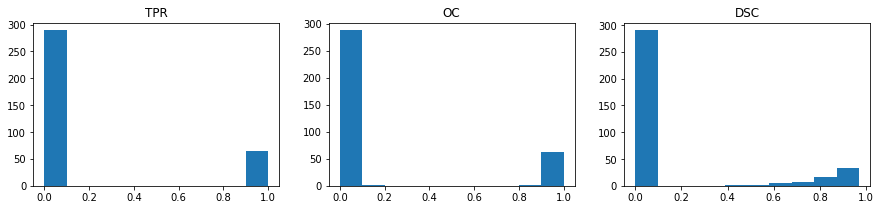

Patient

Mean TPR, OC, DSC:  0.5833333333333334 0.5519952329517611 0.19755712997364708
Median TPR, OC, DSC:  1.0 0.8503939893224346 0.09917036748873882
IQR TPR, OC, DSC:  1.0 0.9783139935515155 0.3451361578837745
CP 90% CI TPR:  (0.3967850681718578, 0.7536113708809807)


In [156]:
df_outcomes_test_maskrcnn_aug = get_outcomes_maskstrategy(sub_names_test, ds_dir, results_dir_aug)

# EMC

In [157]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 'EMC015', 'EMC018', 'EMC020', 
                 'EMC024', 'EMC027', 'EMC029', 'EMC031', 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 
                 'EMC042', 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 'EMC051', 'EMC052', 
                 'EMC054', 'EMC055', 'EMC056', 'EMC057']

In [146]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/u-net_simple/'
results_dir_aug = '../res/maps/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.6947162426614482 0.6651514317919127 0.5681852221090723
Median TPR, OC, DSC:  1.0 0.9712643678160919 0.7664670658682635
IQR TPR, OC, DSC:  1.0 1.0 0.8812622224042429
CP 90% CI TPR:  (0.6594443334045442, 0.7283035876297254)


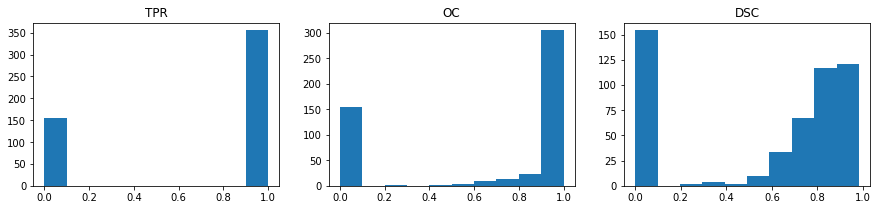

Patient

Mean TPR, OC, DSC:  0.9411764705882353 0.8765593121453248 0.6608528013238084
Median TPR, OC, DSC:  1.0 0.9452386331266477 0.7248151487342822
IQR TPR, OC, DSC:  0.0 0.12981487409355252 0.18709872921713233
CP 90% CI TPR:  (0.8261886934616913, 0.989446950291316)


In [147]:
df_outcomes_emc_unet_simple = get_outcomes_mapstrategy(sub_names_emc, ds_dir, results_dir_simple, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.6947162426614482 0.6731722568500312 0.6028880180389821
Median TPR, OC, DSC:  1.0 0.9696969696969697 0.837037037037037
IQR TPR, OC, DSC:  1.0 0.9973360859263043 0.9246311927223152
CP 90% CI TPR:  (0.6594443334045442, 0.7283035876297254)


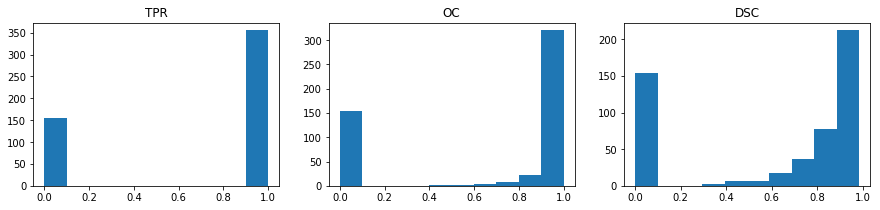

Patient

Mean TPR, OC, DSC:  0.9705882352941176 0.9056160791791174 0.7149351670196672
Median TPR, OC, DSC:  1.0 0.9421753280338656 0.7754793837658267
IQR TPR, OC, DSC:  0.0 0.08334223574387278 0.2310791245719207
CP 90% CI TPR:  (0.867926174868522, 0.9984925110991039)


In [148]:
df_outcomes_emc_unet_aug = get_outcomes_mapstrategy(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [149]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/plaq-u-net_simple/'
results_dir_aug = '../res/maps/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.5342465753424658 0.5297159371865922 0.32913791804821046
Median TPR, OC, DSC:  1.0 0.9902912621359223 0.3012987012987013
IQR TPR, OC, DSC:  1.0 1.0 0.6475118290096264
CP 90% CI TPR:  (0.496893438811138, 0.5713042284917957)


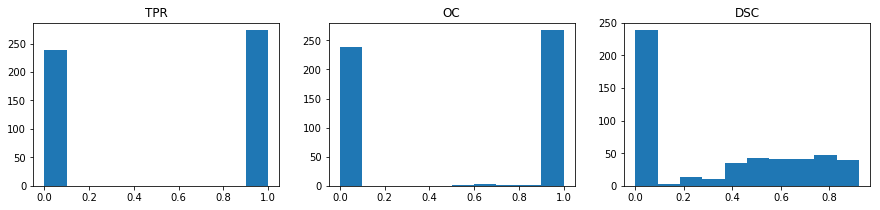

Patient

Mean TPR, OC, DSC:  0.8529411764705882 0.8447084952351931 0.351656949831785
Median TPR, OC, DSC:  1.0 1.0 0.36552607219993827
IQR TPR, OC, DSC:  0.0 0.03131676190561028 0.4877165994620606
CP 90% CI TPR:  (0.7153513351429466, 0.9402144969957976)


In [150]:
df_outcomes_emc_plaqunet_simple = get_outcomes_mapstrategy(sub_names_emc, ds_dir, results_dir_simple, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8317025440313112 0.8229656315478037 0.6767430371389193
Median TPR, OC, DSC:  1.0 1.0 0.821917808219178
IQR TPR, OC, DSC:  0.0 0.021610084706196186 0.2630629277860572
CP 90% CI TPR:  (0.8020860731518331, 0.8584261977439656)


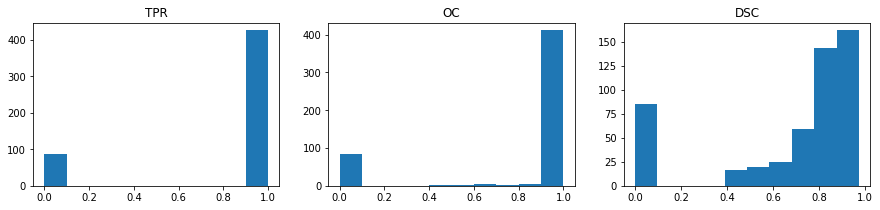

Patient

Mean TPR, OC, DSC:  1.0 0.9716057036008692 0.7146965826796193
Median TPR, OC, DSC:  1.0 0.9950166753039288 0.7511119348840948
IQR TPR, OC, DSC:  0.0 0.03228056071868868 0.20115207176460792
CP 90% CI TPR:  (0.9156603566493746, 1.0)


In [151]:
df_outcomes_emc_plaqunet_aug = get_outcomes_mapstrategy(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [158]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/mask-rcnn_simple/'
results_dir_aug = '../res/maps/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.0410958904109589 0.04115596667632631 0.03385083296044187
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.02770034824014573, 0.05864194412165896)


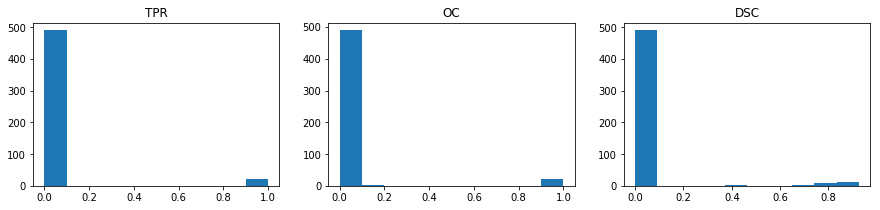

Patient

Mean TPR, OC, DSC:  0.20588235294117646 0.20906938850640927 0.04489134975071139
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.013888888888888888 0.00031113876789047915
CP 90% CI TPR:  (0.10083689953501082, 0.35216121698618397)


In [159]:
df_outcomes_emc_maskrcnn_simple = get_outcomes_maskstrategy(sub_names_emc, ds_dir, results_dir_simple, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.01761252446183953 0.017852150644993812 0.01187294725562506
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.009218229505547496, 0.030532713913909916)


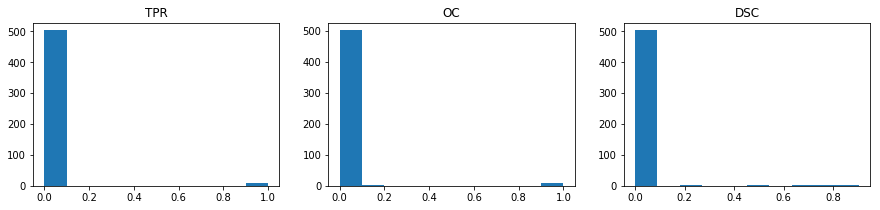

Patient

Mean TPR, OC, DSC:  0.23529411764705882 0.23889555822328934 0.016773641692857076
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.09183673469387754 0.0018687707641196012
CP 90% CI TPR:  (0.12282976558880637, 0.3846567466725869)


In [160]:
df_outcomes_emc_maskrcnn_aug = get_outcomes_maskstrategy(sub_names_emc, ds_dir, results_dir_aug, cut=False)